In [143]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb


# Evaluation


In [144]:
op = pd.read_csv('order_products__train.csv')
opp = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
tips_tr = pd.read_csv('tip_trainingsdaten.csv', index_col=0)
tips_te = pd.read_csv('tip_testdaten.csv', index_col=0)

c:\Users\jdhau\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [145]:
instacart_train = tips_tr.merge(orders)
instacart_train.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,1,prior,2,3,7,15.0
2,473747,1,1,prior,3,3,12,21.0
3,2254736,1,1,prior,4,4,7,29.0
4,431534,1,1,prior,5,4,15,28.0


In [146]:
instacart_train.eval_set.value_counts()

prior    3214874
Name: eval_set, dtype: int64

In [147]:
instacart_test = tips_te.merge(orders)
instacart_test.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,NaN,1,train,11,4,8,14.0
1,1492625,NaN,2,train,15,1,11,30.0
2,2196797,NaN,5,train,5,0,11,6.0
3,525192,NaN,7,train,21,2,11,6.0
4,880375,NaN,8,train,4,1,14,10.0


In [148]:
instacart_test.eval_set.value_counts()

train    131209
Name: eval_set, dtype: int64

In [149]:
instacart_test['days_since_prior_order'].isna().sum()

0

# Business Understanding

In der Aufgaben geht es um einen Lieferdienst namens Instacart, bei dem Kunden Bestellungen aufgeben
können. Instacart schickt dann Fahrer los , die die Ware in
Supermärkten abholen und zum Kunden bringen. 
<br>
Dieser Datensatz enthält eine zusätzliche Spalte „Tip“, die zu den einzelnen
Bestellungen angibt, ob der Kunden beim Erhalt der Ware ein Trinkgeld gegeben hat oder nicht. Kern
der Aufgabe ist vorherzusagen, bei welchen Bestellungen Trinkgeld gegeben werden wird und bei
welchen nicht. 

### 1. Tip-Prediction
Es soll vorhergesagt werden, bei welchen Bestellungen die Kunden dem Fahrer Trinkgeld
gegeben werden und bei welchen nicht. Die Vorhersage kann dabei auf allen Informationen
basieren, die unmittelbar nach Aufgeben der Bestellung zur Verfügung stehen, d.h. alle
Daten zur aktuellen Bestellung sowie die gesamte Vorgeschichte. 
Zielerwartung sind mindestens 70% Genauigkeit bei der Vorhersage, ob ein Tip erfolgen wird oder nicht.

### 2. Analyse der Tip-Einflussfaktoren
Zusätzlich sollen auch interpretierbare Erkenntnisse geliefert werden, wovon es abhängt, ob
Trinkgeld gegeben wird. Diese sollen nachvollziehbar dargestellt werden. 

# Data Understanding

## Daten sammeln

- To-Do: Verknüpfung weiterer Daten zu den Bestellungen über Order-Products

## Beschreibung der Daten

Der Instacart Datensatz besteht aus über 3.2 Millionen Bestellungen. Die Daten pro Bestellung sind vollständig, bis auf den Wochentag der Bestellung (order_dow), bei dem Werte mit nan angegeben sind und was später ersetzt werden wird. Alle Daten sind ganzzahlige Werte (int), außer days_since_prior_order, welches ein Kommazahlenwert (float) ist. Eine weitere Ausnahme ist das Objekt eval_set. 

- To-Do: Textuelle Beschreibung der Spalten

In [150]:
instacart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3214873
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   tip                     int64  
 2   user_id                 int64  
 3   eval_set                object 
 4   order_number            int64  
 5   order_dow               int64  
 6   order_hour_of_day       int64  
 7   days_since_prior_order  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 220.7+ MB


### order_id (int)
- Numerisches Features, welches für jede Bestellung eine einzigartige ID enthält. Insgesamt gibt es 3.214.874 Millionen distinkte Bestellungen.

In [151]:
instacart_train['order_id'].nunique()

3214874

### user_id (int)
- Numerisches Feature, welches für jeden distinkten Nutzer eine einzigeartige ID enthält. Die Bestellungen wurden von 206209 distinkten Nutzern getätigt.

In [152]:
instacart_train['user_id'].nunique()

206209

### tip (int)
- Binäres Features mit der Information, ob ein Tip gebeben wurde. 0 bedeutet, dass kein Tip gegeben wurde, 1 bedeutet, dass ein Tip gegeben wurde. 
- Bei circa 1.9 Millionen Bestellungen wurde Trinkgeld gegeben, bei 1.4 Millionen nicht. 

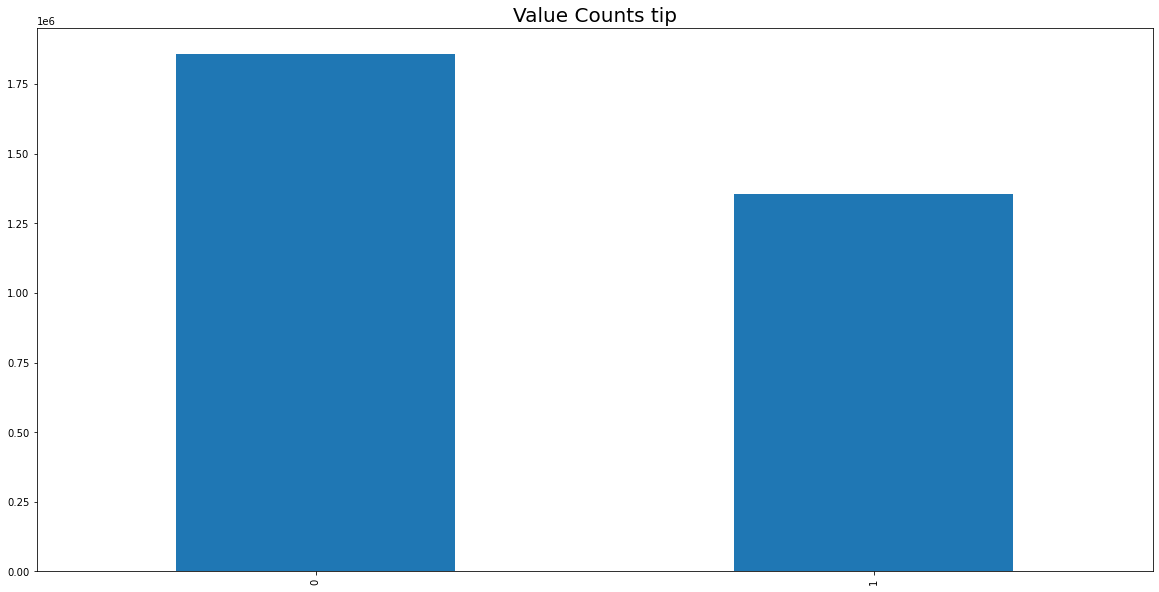

In [153]:
plt.figure(figsize=(20, 10))
ax = instacart_train['tip'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts tip', fontsize = 20)
plt.show()

### eval_set
- Kategorisches Features mit der Information zu welchem Set die Beobachtung gehört. Verfügbare Werte sind: train und test. Train kann für das Training benutzt werden. Für Test-Beobachtungen soll eine Vorhersage generiert werden. Das Feature ist daher im Trainingsset stetig und enthält keine weitere Information.

In [154]:
instacart_train['eval_set'].nunique()

1

### order_number
- Numerisches Features mit der Information, die wievielte Bestellung die des jeweiligen Nutzers die Beobachtung ist.
- Jede Person hat mindestens 3 Mal und maximal 99 Mal bestellt. Durchschnittlich hat jede Person ca. 17 Bestellungen aufgegeben. 

In [155]:
instacart_train['order_number'].mean()

17.191065652961825

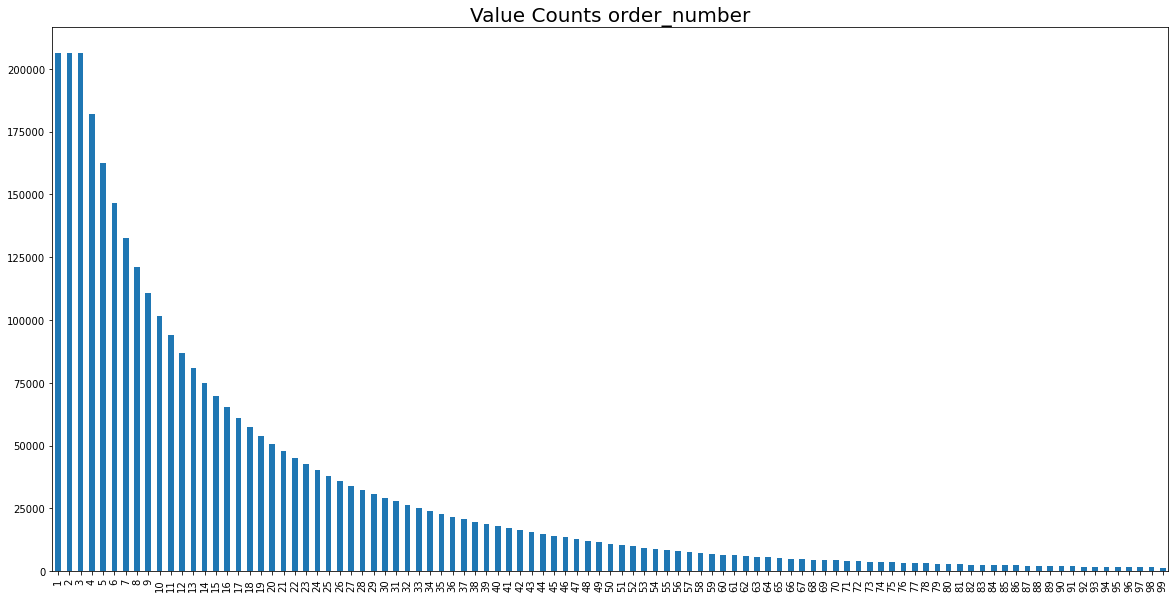

In [156]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_number'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_number', fontsize = 20)
plt.show()

### order_dow
- Numerisches Features mit der Information über den Wochentag der Bestellung. Die Information ist als Zahl zwischen 0 und 6 encodiert. Es wird angenommen, dass die Tage 0 und 1 mit mehr Bestellungen die Tage Samstag und Sonntag sind. Die weiteren Tage sind in der üblichen Reihenfolge.

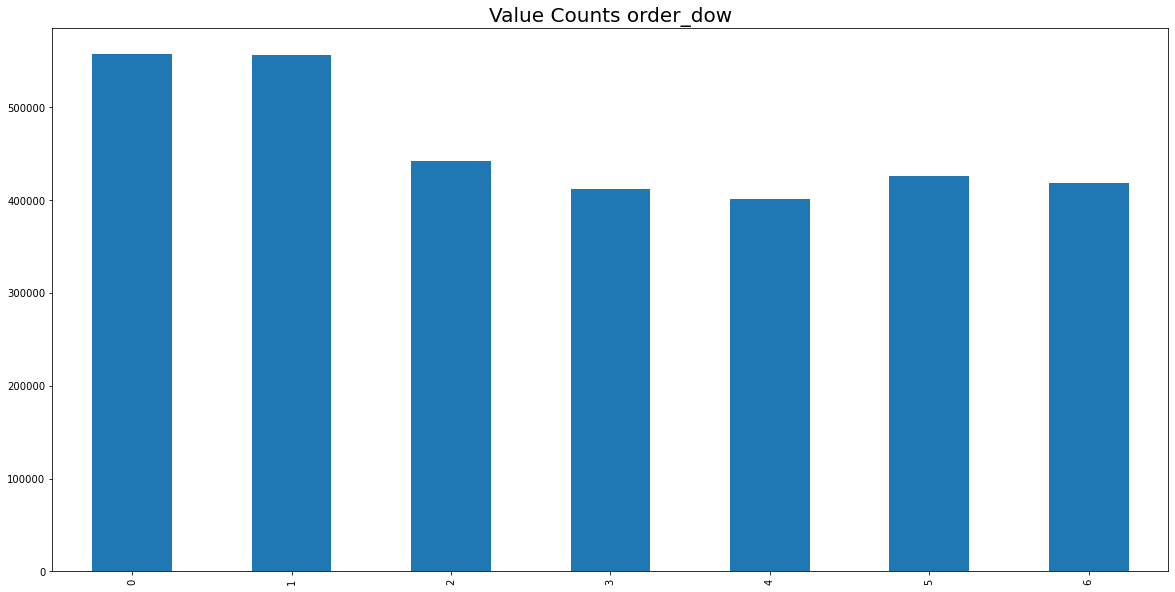

In [157]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_dow'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_dow', fontsize = 20)
plt.show()

### order_hour_of_day
- Numerisches Features mit der Information über die Uhrzeit der Bestellung.
- Die wenigsten Bestellungen gehen rund um 3 Uhr nachts ein, die meisten um 10 Uhr vormittags. 

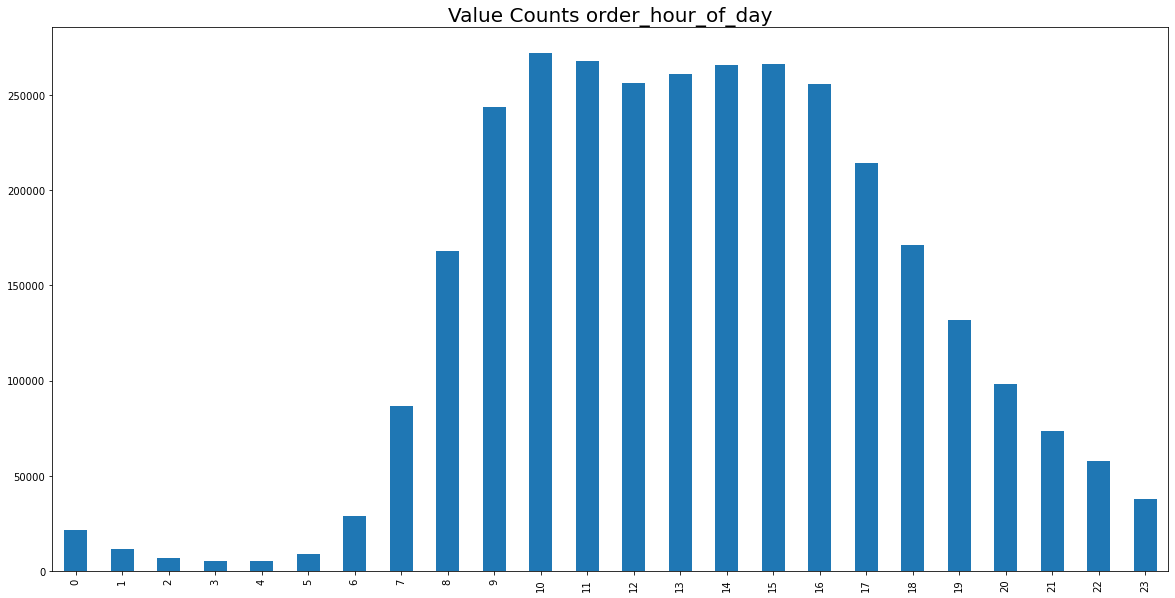

In [158]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_hour_of_day'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_hour_of_day', fontsize = 20)
plt.show()

### days_since_prior_order
- Numerisches Feature mit der Information über die Anzahl der vergangengen Tage seit der letzten seit der letzten Bestellung.
- Es vergehen zwischen keinem und mehr als 30 Tage, bis die Personen erneut bestellen. Der Durchschnitt des Features ist alle 10,7 Tage.

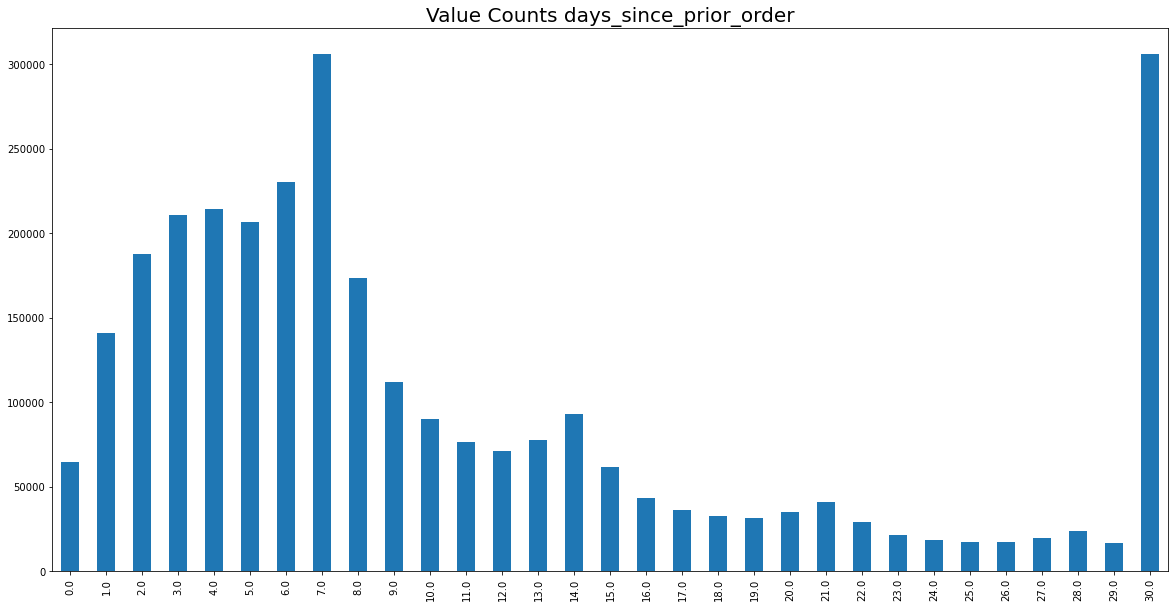

In [159]:
plt.figure(figsize=(20, 10))
ax = instacart_train['days_since_prior_order'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts days_since_prior_order', fontsize = 20)
plt.show()

In [160]:
print('Description of instacart_train: ', instacart_train.shape)
instacart_train.head(10)

Description of instacart_train:  (3214874, 8)


,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,1,prior,2,3,7,15.0
2,473747,1,1,prior,3,3,12,21.0
3,2254736,1,1,prior,4,4,7,29.0
4,431534,1,1,prior,5,4,15,28.0
5,3367565,1,1,prior,6,2,7,19.0
6,550135,1,1,prior,7,1,9,20.0
7,3108588,1,1,prior,8,1,14,14.0
8,2295261,1,1,prior,9,1,16,0.0
9,2550362,1,1,prior,10,4,8,30.0


Beschreibung des products Datensatzes:

Es sind fast 50.000 Produkte vorhanden, welche über 4 Spalten beschrieben werden. Der Datensatz ist vollständig, es gibt keine Null-Werte. 

In [161]:
products.shape

(49688, 4)

In [162]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Daten verstehen

In [163]:
instacart_train.describe()

,order_id,tip,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.008665e+06
mean,1.710827e+06,4.217627e-01,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,1.070724e+01
std,9.875206e+05,4.938411e-01,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,8.954180e+00
min,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,0.000000e+00,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711120e+06,0.000000e+00,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.566034e+06,1.000000e+00,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,1.000000e+00,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


- Weitere Fragestellungen
    - DOW zu Tip
    - Uhrzeit zu Tip
    - Days since prior order zu Tip
    - Order Number zu Tip
    - Departments zu Tip
    - Aisles zu Tip
    - Anzahl Produkte in der Bestellung zu Tip
    - Top Nutzer nach Tip, Neg Nutzer nach Tip
    - Products zu Tip (Top 20?, Neg 20?)

### User zu tip
- Je höher die durchschnittliche tip-Wahrscheinlichkeit des Nutzers ist, dest höher ist die Wahrscheinlichkeit, dass er auch bei der vorliegenden Bestellung einen tip geben hat.
- Auch bei der Betrachtung der (1 und 3) direkt zuvor erfolgen Bestellung. ist eine Korrelation der vorherigen tips mit der tip-Wahrscheinlichkeit für die vorliegende Bestellung wahrscheinlich. 

In [164]:
# Order the dataframe by user_id and order_number
instacart_train = instacart_train.sort_values(['user_id', 'order_number'], ascending = [True, True])

# Shift the value previous tips per user and fill Nans with 0s
instacart_train['previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(1)
instacart_train['previous_order_tip']= instacart_train['previous_order_tip'].fillna(0)
instacart_train['2_previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(2)
instacart_train['2_previous_order_tip']= instacart_train['2_previous_order_tip'].fillna(0)
instacart_train['3_previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(3)
instacart_train['3_previous_order_tip']= instacart_train['3_previous_order_tip'].fillna(0)
instacart_train['3_previous_tip_user'] = (instacart_train['previous_order_tip'] + instacart_train['2_previous_order_tip'] + instacart_train['3_previous_order_tip']) / 3
instacart_train['3_previous_tip_user'].round(1)
instacart_train = instacart_train.drop(columns=['3_previous_order_tip', '2_previous_order_tip'])

# Get the mean tip value per user
instacart_train['mean_tip_user'] = instacart_train.groupby('user_id')['tip'].transform('mean')
instacart_train['mean_tip_user'] = instacart_train['mean_tip_user'].round(1)

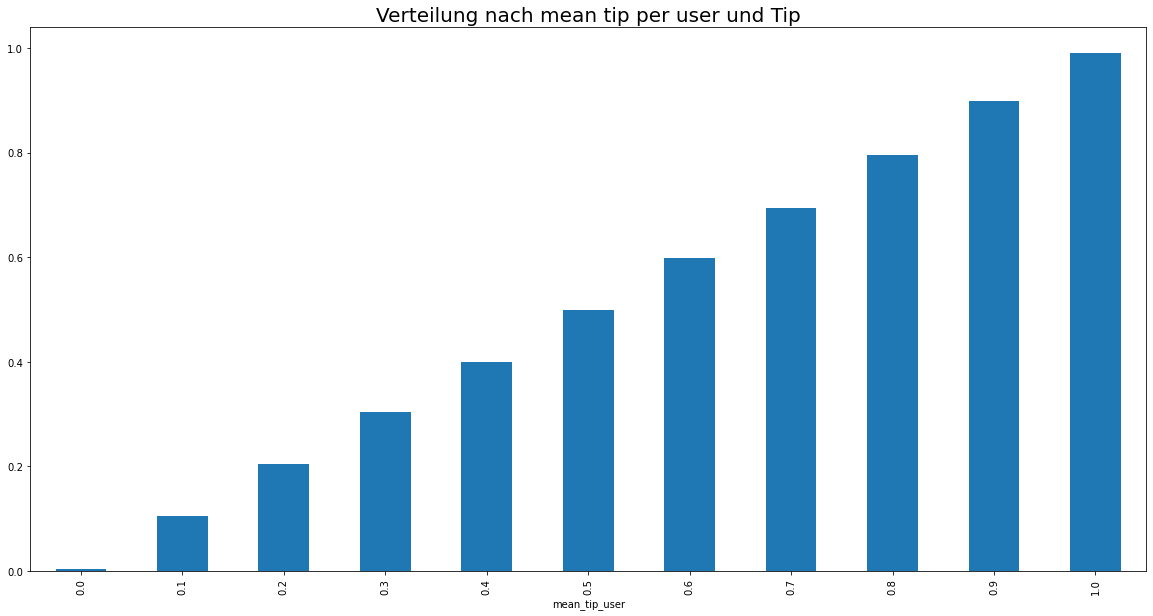

In [165]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('mean_tip_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach mean tip per user und Tip', fontsize = 20)
plt.show()

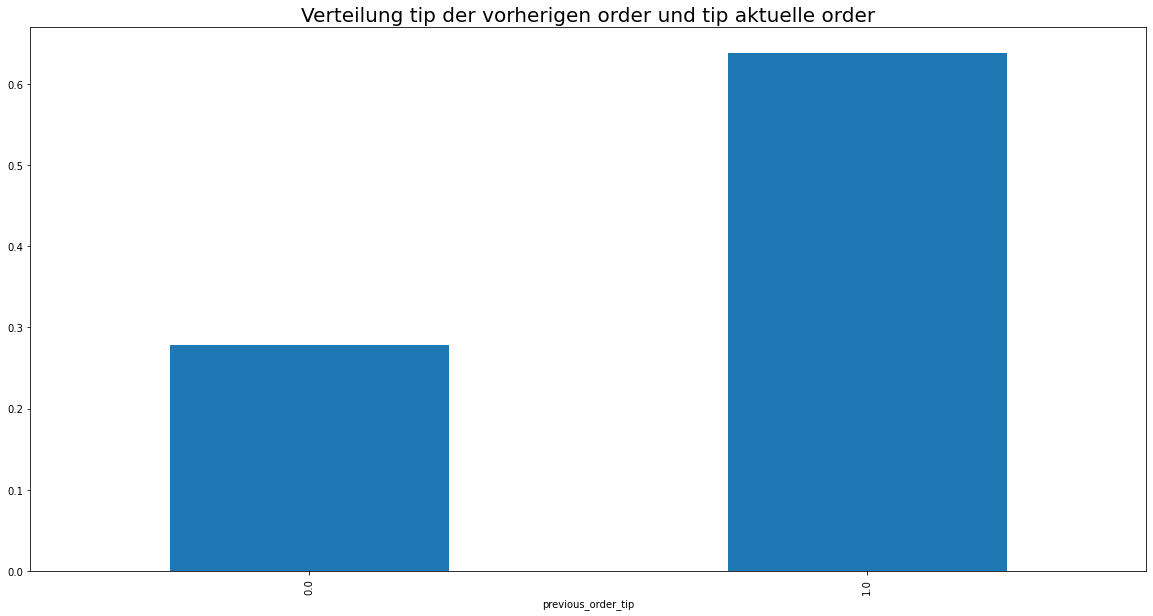

In [166]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('previous_order_tip').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung tip der vorherigen order und tip aktuelle order', fontsize = 20)
plt.show()

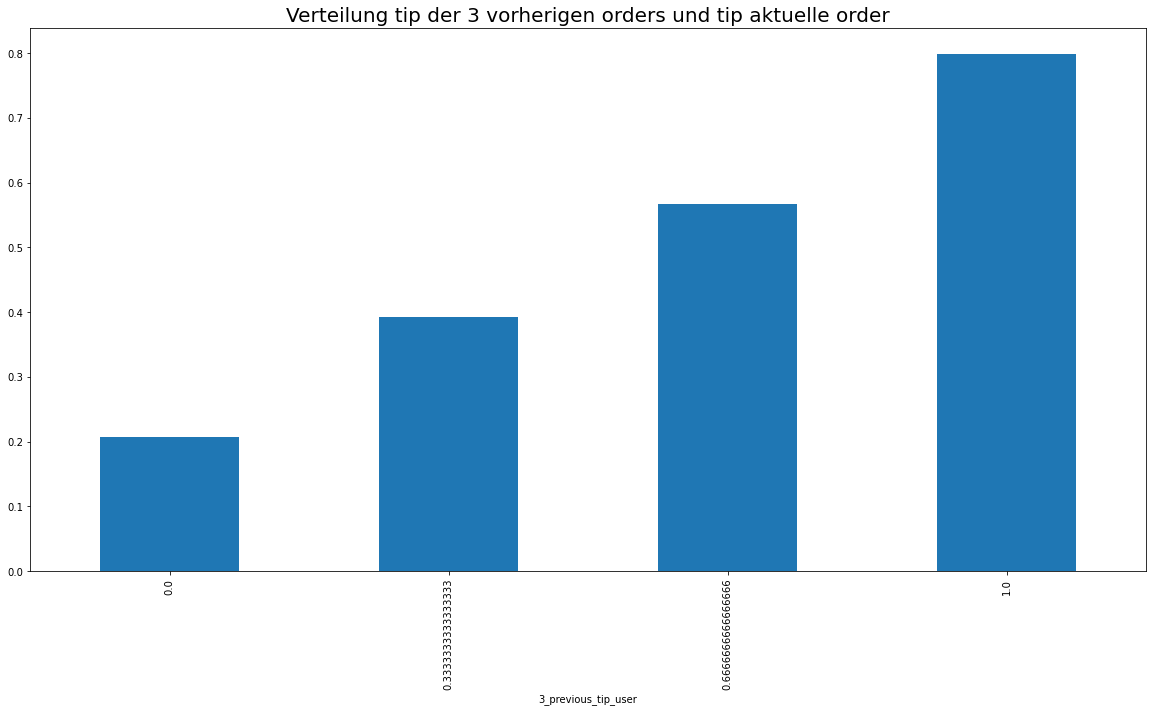

In [167]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('3_previous_tip_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung tip der 3 vorherigen orders und tip aktuelle order', fontsize = 20)
plt.show()

### Day of week zu tip
- Samstag und Sonntag ist die Wahrscheinlichkeit, dass ein tip gegeben wird, um ca. 0,1 höher. Der Unterschied ist statistisch signifikant, da für alle Ausprägungen ausreichend Beobachtungen vorliegen.

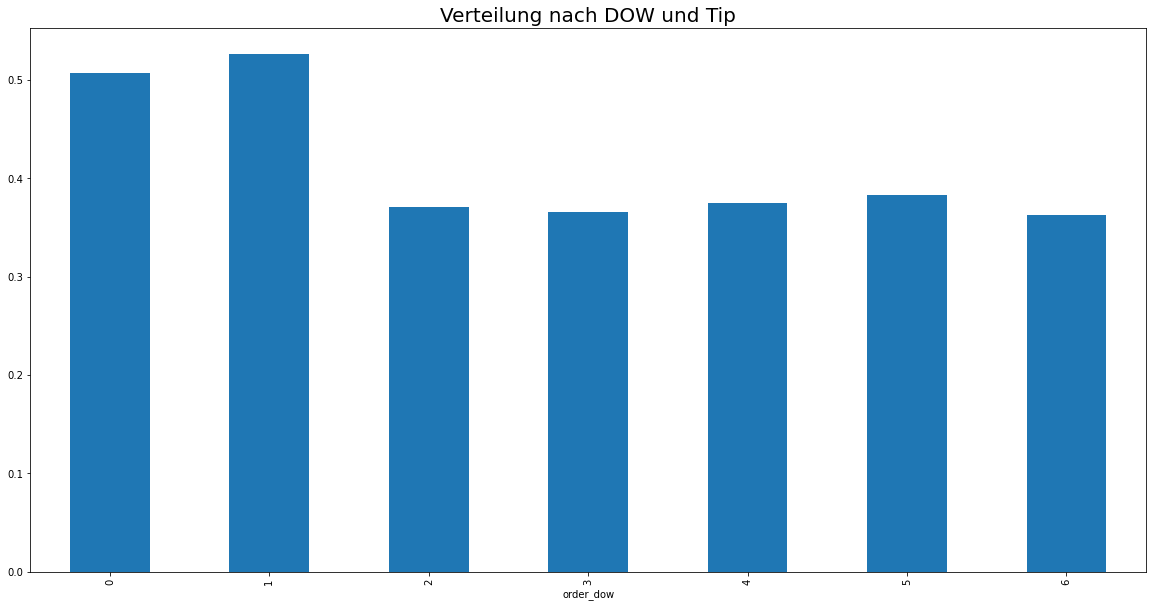

In [168]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_dow').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach DOW und Tip', fontsize = 20)
plt.show()

### Hour of day zu tip
- Zwischen 19 Uhr und 4 Uhr scheint die Wahrscheinlichkeit, dass ein tip gegegeben wird, um ca. 0,1 höher. Ca. 14% der Bestellungen fallen in diesen Zeitraum. Somit scheint der Unterschied auch statistisch signifikant zu sein.

Ca. 13.955476948707787% der Bestellungen wurden in zwischen 19 und 4 Uhr aufgegeben.


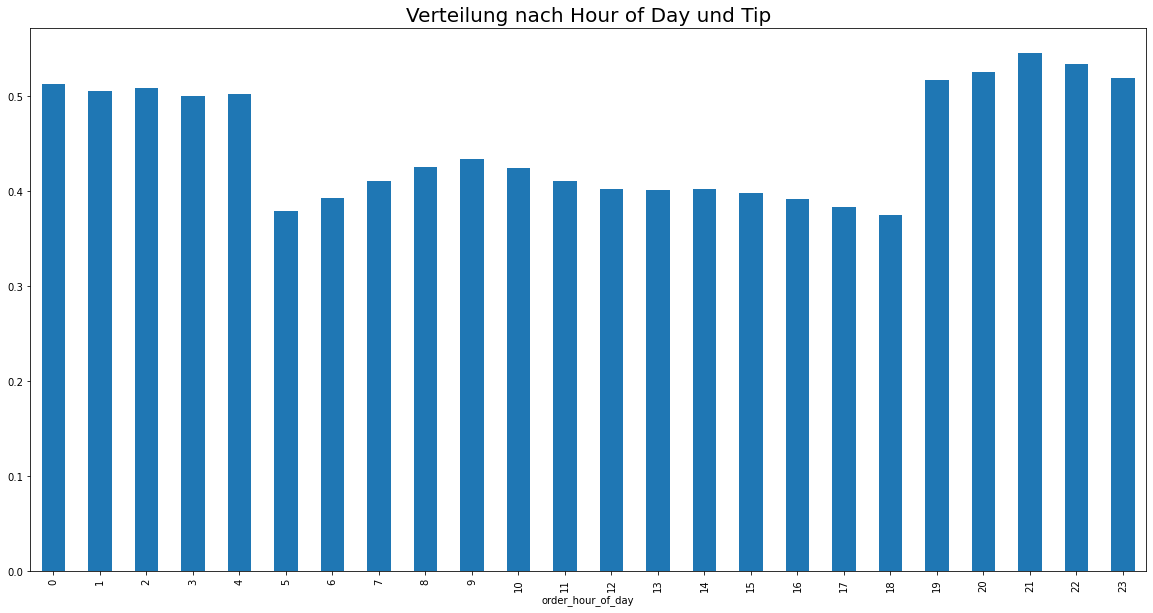

In [169]:
night_percentage = len(instacart_train[(instacart_train['order_hour_of_day'] < 5) | (instacart_train['order_hour_of_day'] > 18)]) / len(instacart_train)
print(f'Ca. {night_percentage*100}% der Bestellungen wurden in zwischen 19 und 4 Uhr aufgegeben.')
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_hour_of_day').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Hour of Day und Tip', fontsize = 20)
plt.show()

### Days since prior order zu tip

- Aufwärtstrend in der ersten Woche an den Tagen 1-7 erkennbar.
- Erste Trendkomponente: Statistisch signifikanter Abwärtstrend hinsichtlich der tip-Wahrscheinlichkeit ab Beginn der zweiten Woche. (Siehe Abbildung Verteilung nach Weeks since prior order und tip)
- Zweite Trendkomponente: Statistisch signifkant höherer tip-Wahrscheinlichkeit, wenn relativ gesehen wieder an denselben Wochentagen bestellt wird (Erste Bestellung Dienstags, zweite Bestellung Dienstags). Dagegen deutlich geringere tip-Wahrscheinlichkeit, wenn zwei Wochentage später die nächste Bestellung erfolgt (Erste Bestellung Dienstags, zweite Bestellung Donnerstags) (Siehe Abbildung Verteilung nach relative day since prior order und tip)

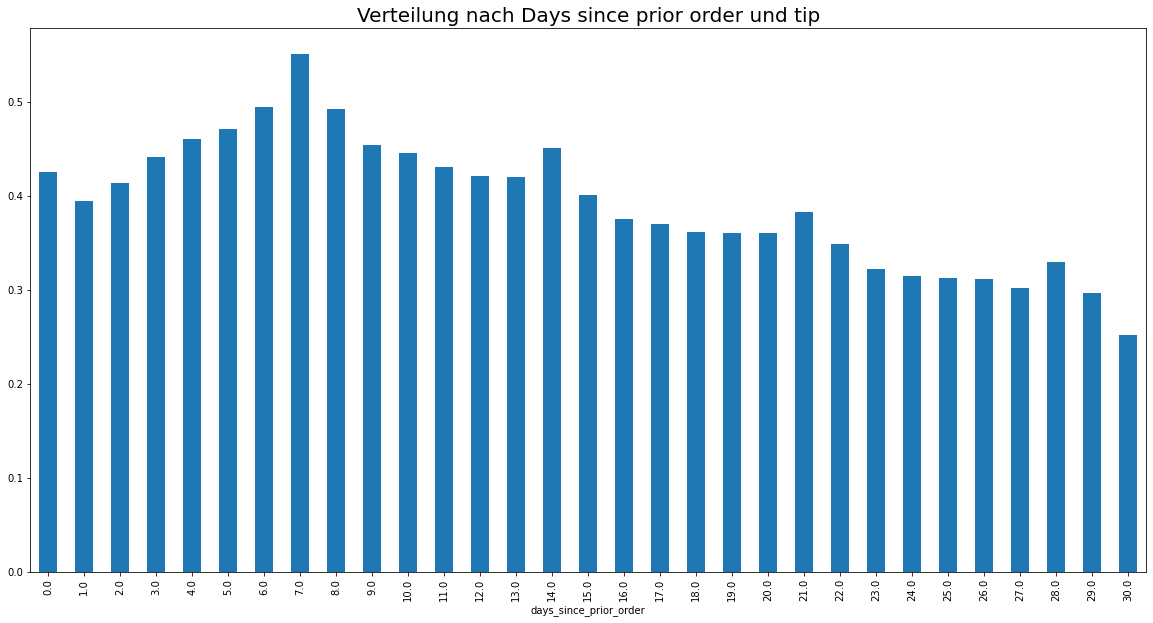

In [170]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('days_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Days since prior order und tip', fontsize = 20)
plt.show()

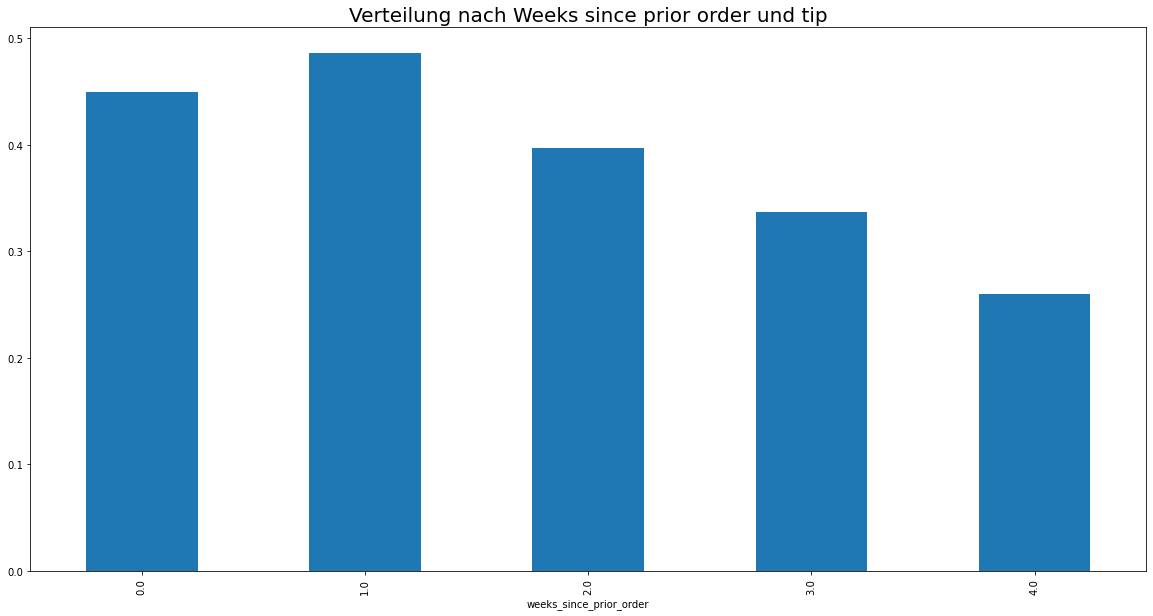

In [171]:
plt.figure(figsize=(20, 10))
instacart_train['weeks_since_prior_order'] = instacart_train['days_since_prior_order'] // 7
ax = instacart_train.groupby('weeks_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Weeks since prior order und tip', fontsize = 20)
plt.show()

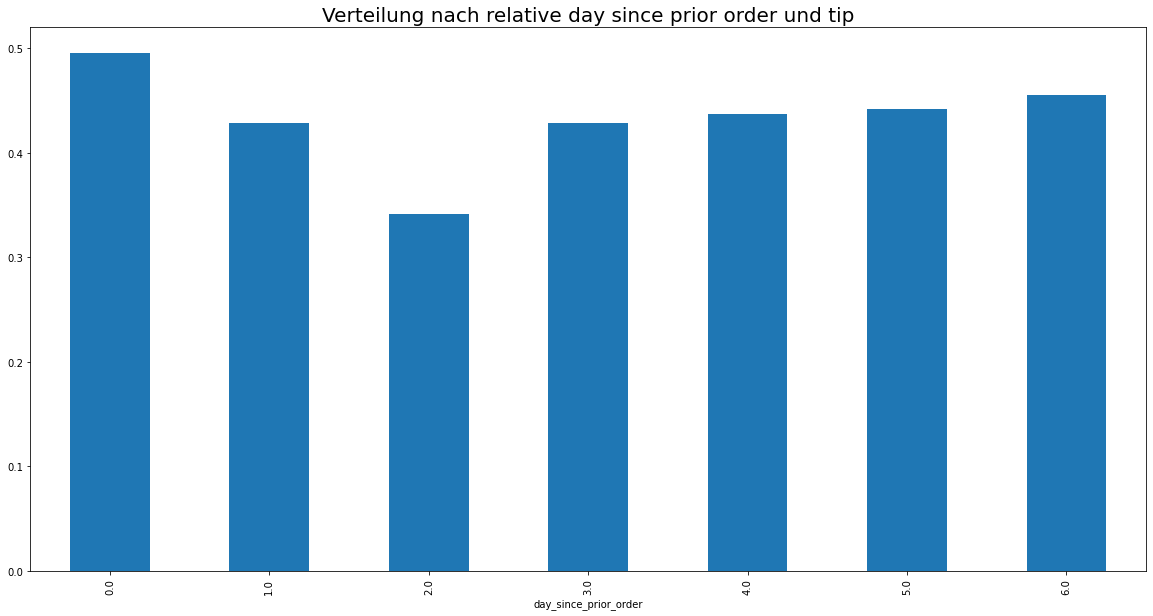

In [172]:
plt.figure(figsize=(20, 10))
instacart_train['day_since_prior_order'] = instacart_train['days_since_prior_order'] % 7
ax = instacart_train.groupby('day_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach relative day since prior order und tip', fontsize = 20)
plt.show()

### Mean days since prior order per User zu tip
- Nutzer, die im Durschnitt nach 0 bis 7 Tagen erneut bestellen haben eine stark steigende tip-Wahrscheinlichkeit.
- Die höchste tip-Wahrscheinlichkeit haben Nutzer, die durchschnittlichen nach genau 7 Tagen erneut bestellen.
- Nutzer, die im Durchscnitt mehr nach mehr als 7 Tagen erneut bestellen, haben eine sinkende tip-Wahrscheinlichkeit.

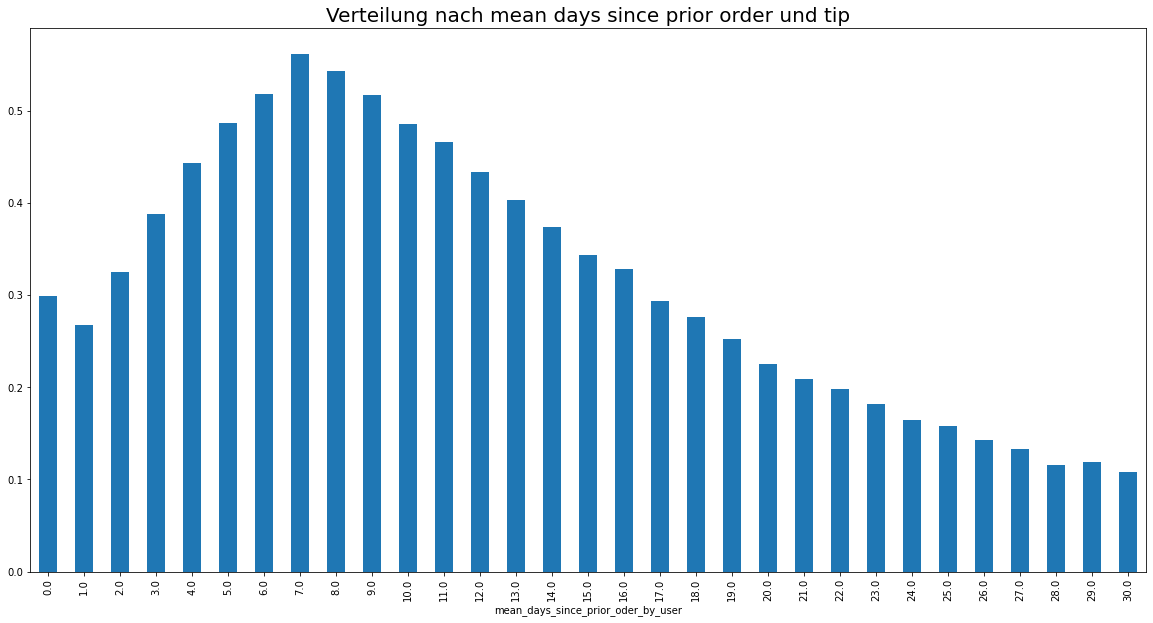

In [173]:
plt.figure(figsize=(20, 10))
instacart_train['mean_days_since_prior_oder_by_user'] = instacart_train.groupby('user_id')['days_since_prior_order'].transform('mean')
instacart_train['mean_days_since_prior_oder_by_user'] = instacart_train['mean_days_since_prior_oder_by_user'].round(0)
ax = instacart_train.groupby('mean_days_since_prior_oder_by_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach mean days since prior order und tip', fontsize = 20)
plt.show()

### Order number zu tip
- Mit der Anzahl der Bestellungen nimmt die tip-Wahrscheinlichkeit zunächst stetig zu. 
- Die höchste tip-Wahrscheinlichkeit kann für die Nutzer bei der 35. Bestellung beobachtet werden. Bei ca. 52% der 35. Bestellungen wurde ein tip gegeben.
- Bei mehr als 35 Bestellungen beginnt die tip-Wahrscheinlichkeit wieder zu sinken. Je höher die Anzahl der Bestellungen, desto weniger Beobachtungen liegen für vor. Dennoch sind die Trends signifikant.

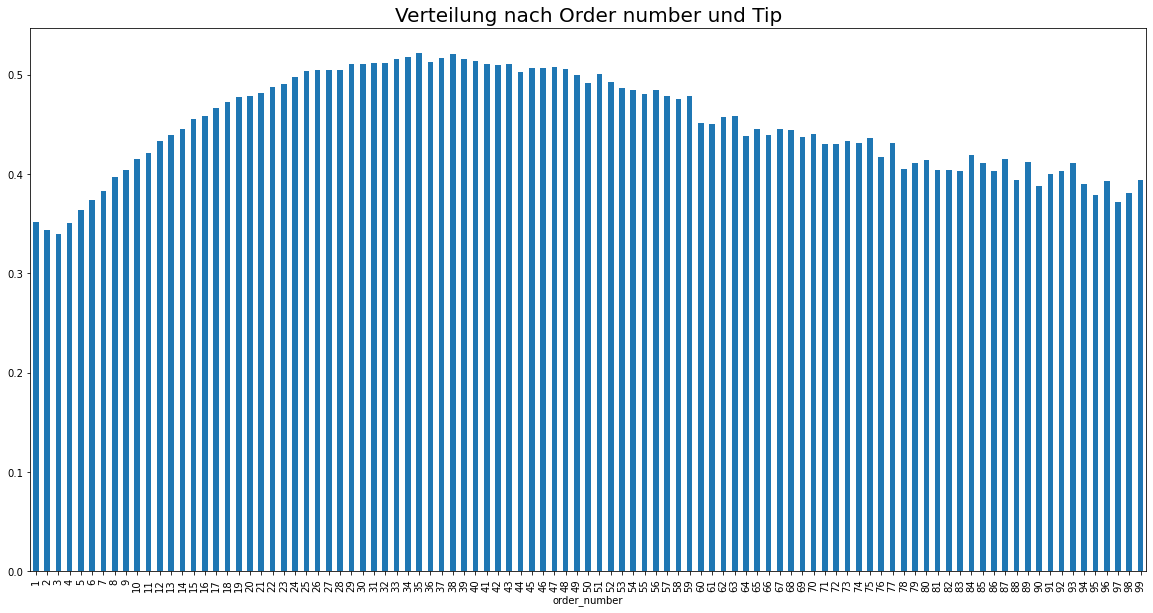

In [175]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_number').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Order number und Tip', fontsize = 20)
plt.show()

## Korrelationen

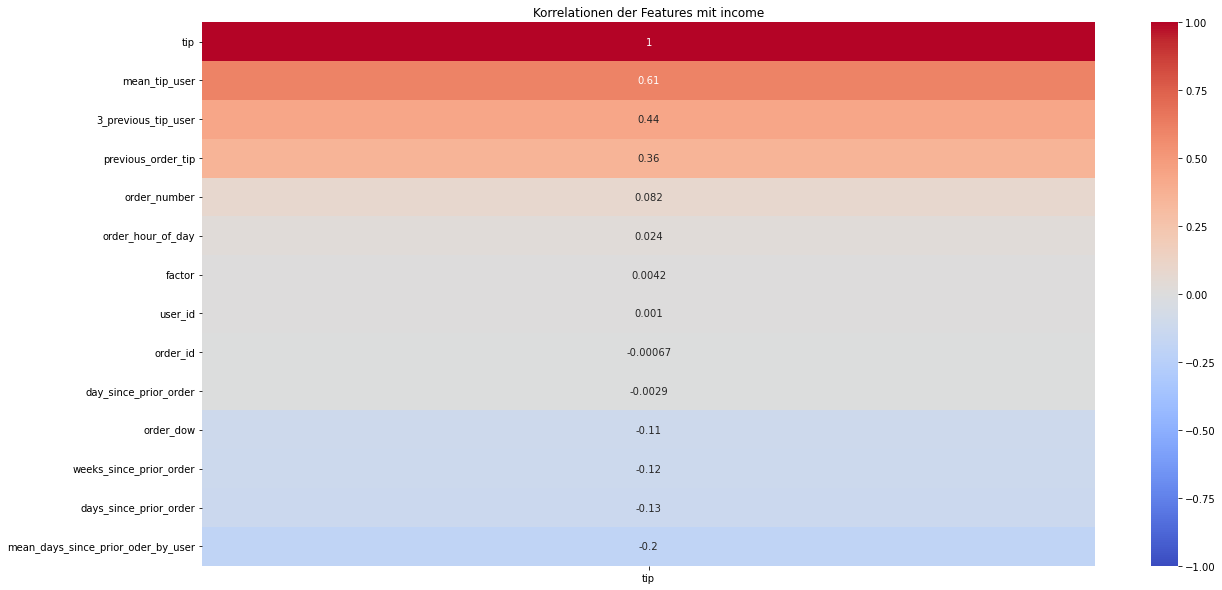

In [176]:
plt.figure(figsize=(20, 10))
corr_with_income = instacart_train.corr()[['tip']].sort_values(by='tip', ascending=False)
heatmap = sns.heatmap(corr_with_income, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Korrelationen der Features mit income')
plt.show()

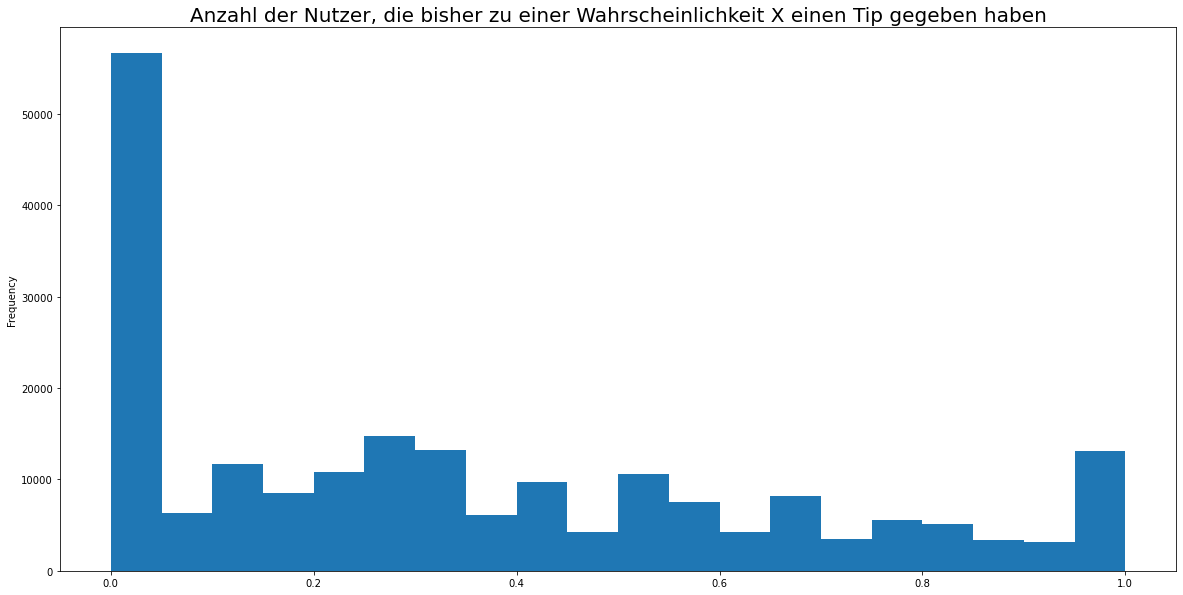

In [177]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('user_id').tip.mean().plot.hist(bins=20)
ax.set_title(label = 'Anzahl der Nutzer, die bisher zu einer Wahrscheinlichkeit X einen Tip gegeben haben', fontsize = 20)
plt.show()

## Datenqualität analysieren

### Outliers
- ToDo: Outlier auswerten und behandeln

### Missing Values
- ToDo: Missing values auswerten und behandeln

In [178]:
instacart_train.isna().sum()

order_id                                   0
tip                                        0
user_id                                    0
eval_set                                   0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                206209
previous_order_tip                         0
3_previous_tip_user                        0
mean_tip_user                              0
weeks_since_prior_order               206209
day_since_prior_order                 206209
mean_days_since_prior_oder_by_user         0
factor                                206604
dtype: int64

In [179]:
instacart_train['days_since_prior_order']= instacart_train['days_since_prior_order'].fillna(instacart_train['days_since_prior_order'].mean())

In [180]:
instacart_train.isna().sum()

order_id                                   0
tip                                        0
user_id                                    0
eval_set                                   0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                     0
previous_order_tip                         0
3_previous_tip_user                        0
mean_tip_user                              0
weeks_since_prior_order               206209
day_since_prior_order                 206209
mean_days_since_prior_oder_by_user         0
factor                                206604
dtype: int64

## Optimierung der Datentypen

In [181]:
''' 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
'''
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object]:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

instacart_train = reduce_mem_usage(instacart_train)

# 

Memory usage of dataframe is 392.44 MB
Memory usage after optimization is: 131.84 MB
Decreased by 66.4%


# Data Preparation

- Feature Engineering
    - Trinkgeld bei der letzten Bestellung
    - Durchschnitt für User
    - Anzahl der Produkte pro Bestellung

- Feature Selection
    - chi2
    - f-Value
    - eval_set: Löschen, da kein Zusammenhang mit Zielvariable

- Encoding

## Feature Engineering

### Discretization

- ToDo: Discretize order_dow in weekend and weekday

- ToDo: Discretize days_since_prior_oder

### Feature Creation

Create Feature: previous_order_tip mit der Information, ob der Nutzer in der vorhergehenden Bestellungen einen Tip vergeben hat.

In [182]:
instacart_train

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,factor
0,2539329,1,1,prior,1,2,8,10.710938,0.0,0.000000,1.000000,NaN,NaN,20.0,NaN
1,2398795,1,1,prior,2,3,7,15.000000,1.0,0.333252,1.000000,2.0,1.0,20.0,0.8
2,473747,1,1,prior,3,3,12,21.000000,1.0,0.666504,1.000000,3.0,0.0,20.0,1.0
3,2254736,1,1,prior,4,4,7,29.000000,1.0,1.000000,1.000000,4.0,1.0,20.0,1.4
4,431534,1,1,prior,5,4,15,28.000000,1.0,1.000000,1.000000,4.0,0.0,20.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214869,2558525,0,206209,prior,9,4,15,22.000000,0.0,0.000000,0.399902,3.0,1.0,18.0,1.2
3214870,2266710,0,206209,prior,10,5,18,29.000000,0.0,0.000000,0.399902,4.0,1.0,18.0,1.6
3214871,1854736,0,206209,prior,11,4,10,30.000000,0.0,0.000000,0.399902,4.0,2.0,18.0,1.7
3214872,626363,1,206209,prior,12,1,12,18.000000,0.0,0.000000,0.399902,2.0,4.0,18.0,1.0


mean_tip_user

## Feature Selection
- Delete eval_set, da es keinen logischen Zusammenhang gibt.
- Delete order_id, da es eine unique ID ist (führt zu Overfitting)
- Delete user_id, da es eine unique ID ist (führt zu Overfitting)

In [183]:
instacart_train.isnull().sum()

order_id                                   0
tip                                        0
user_id                                    0
eval_set                                   0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                     0
previous_order_tip                         0
3_previous_tip_user                        0
mean_tip_user                              0
weeks_since_prior_order               206209
day_since_prior_order                 206209
mean_days_since_prior_oder_by_user         0
factor                                206604
dtype: int64

In [184]:
instacart_train = instacart_train.dropna()

In [185]:
instacart_train = instacart_train.drop(columns=['eval_set', 'order_id', 'user_id', 'factor'])

# Modeling

- ToDo: Train-Test-Split (80/20)
- ToDo: Train baseline models by CV-Cross-Validation

In [186]:
instacart_train = instacart_train.sample(1000000)

X = instacart_train.drop(columns=['tip'])
y = instacart_train['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [187]:
from sklearn.preprocessing import MinMaxScaler



scaler = MinMaxScaler()
# transform data
X_train = scaler.fit_transform(X_train)


In [188]:
clf = DummyClassifier(strategy="most_frequent")
dummy_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dummy_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dummy_base_scores.mean(), dummy_base_scores.std()))

[0.57360625 0.57360625 0.57360625 0.5736125  0.5736125 ]
0.57 accuracy with a standard deviation of 0.00


In [189]:
# clf = KNeighborsClassifier()
# knn_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
# print(knn_base_scores)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (knn_base_scores.mean(), knn_base_scores.std()))

In [190]:
clf = DecisionTreeClassifier()
dt_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dt_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dt_base_scores.mean(), dt_base_scores.std()))

[0.69969375 0.6997     0.69611875 0.69840625 0.69831875]
0.70 accuracy with a standard deviation of 0.00


In [191]:
clf = RandomForestClassifier(n_estimators=5)
rf_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(rf_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (rf_base_scores.mean(), rf_base_scores.std()))

[0.736075   0.73576875 0.73405    0.73651875 0.7353875 ]
0.74 accuracy with a standard deviation of 0.00


In [192]:
clf = xgb.XGBClassifier()
xgb_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(xgb_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (xgb_base_scores.mean(), xgb_base_scores.std()))

[0.7799125  0.779875   0.77878125 0.77823125 0.77870625]
0.78 accuracy with a standard deviation of 0.00


In [193]:
clf = Perceptron()
perceptron_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(perceptron_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (perceptron_base_scores.mean(), perceptron_base_scores.std()))

[0.70594375 0.75331875 0.7480875  0.75655    0.62518125]
0.72 accuracy with a standard deviation of 0.05


In [194]:
clf = MLPClassifier(random_state=1, max_iter=20)
mlp_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(mlp_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (mlp_base_scores.mean(), mlp_base_scores.std()))

c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

[0.77898125 0.7790875  0.77788125 0.77675    0.777625  ]
0.78 accuracy with a standard deviation of 0.00


In [195]:
baseline_model = [dummy_base_scores, knn_base_scores, dt_base_scores, rf_base_scores, xgb_base_scores, perceptron_base_scores, mlp_base_scores]

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(label = 'Accuracy der Base-Models', fontsize = 20)
 
# Creating plot
bp = ax.boxplot(baseline_model)

# rename ticks 
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Dummy Classifier', 'KNN Classifier', 'Decision Tree', 'Random Forest', 'XGBoost', 'Perceptron', 'MLP Classifier'])
# show plot
plt.show()

NameError: name 'knn_base_scores' is not defined

# Evaluation

- ToDo: Evaluation by Accuracy
- ToDo: Research Additional Metrics

## Feature Importance

### Feature importance based on Mean Decrease in Impurity

Impurits Decrease importances sind bekannt dafür, dass Sie Features mit hoher Kardinalität bevorzugen. Daher wird neber dem Mean Decrease auch die Permutation Importance betrachtet.

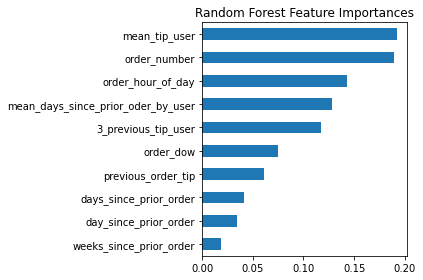

In [196]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

mdi_importances = pd.Series(
    clf[-1].feature_importances_, index=X.columns
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

### Feature importance based on Permutation importance

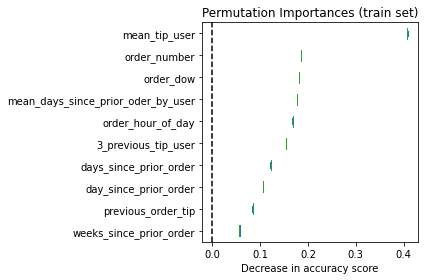

In [197]:
from sklearn.inspection import permutation_importance

clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

permutation_importances = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=0)

sorted_importances_idx = permutation_importances.importances_mean.argsort()
importances = pd.DataFrame(
    permutation_importances.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Hyperparameter